<a href="https://colab.research.google.com/github/Lohitasrith01/Multi-Agent-Autonomous-Drone-Navigation-Using-Reinforcement-Learning-in-AirSim-/blob/main/multi_agent_independent_a3c_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 20.7 MB/s eta 0:00:00


# Multi Agent Environment Definition

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import matplotlib.pyplot as plt

# Hyperparameters
GAMMA = 0.99       # Discount factor
LR = 1e-4          # Learning rate
ENTROPY_WEIGHT = 0.01  # Weight for entropy loss
MAX_EPISODES = 1000
MAX_STEPS = 100
EPISODE_WINDOW = 50

# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, state):
        shared_features = self.shared(state)
        action_probs = self.actor(shared_features)
        state_value = self.critic(shared_features)
        return action_probs, state_value

# Independent A3C Agent
class IndependentA3CAgent:
    def __init__(self, input_dim, action_dim, agent_id):
        self.agent_id = agent_id
        self.model = ActorCritic(input_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.log_probs = []
        self.values = []
        self.rewards = []

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, state_value = self.model(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        self.log_probs.append(dist.log_prob(action))
        self.values.append(state_value)
        return action.item()

    def compute_returns(self, next_value):
        returns = []
        R = next_value
        for reward in reversed(self.rewards):
            R = reward + GAMMA * R
            returns.insert(0, R)
        return returns

    def update(self, next_state, done):
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        _, next_value = self.model(next_state)
        next_value = 0 if done else next_value.item()
        returns = self.compute_returns(next_value)
        returns = torch.FloatTensor(returns)

        log_probs = torch.stack(self.log_probs)
        values = torch.cat(self.values).squeeze()
        advantage = returns - values

        # Losses
        policy_loss = -(log_probs * advantage.detach()).mean()
        value_loss = advantage.pow(2).mean()
        entropy_loss = -(torch.exp(log_probs) * log_probs).mean()

        loss = policy_loss + 0.5 * value_loss - ENTROPY_WEIGHT * entropy_loss

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clear buffers
        self.log_probs = []
        self.values = []
        self.rewards = []

# Training Independent Networks
def train_independent_a3c(env, num_agents):
    agents = [IndependentA3CAgent(env.observation_space.shape[1], env.action_space.nvec[0], i) for i in range(num_agents)]
    episode_rewards = deque(maxlen=EPISODE_WINDOW)
    total_rewards_per_episode = []

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        total_rewards = np.zeros(num_agents)

        for step in range(MAX_STEPS):
            actions = [agents[i].select_action(state[i]) for i in range(num_agents)]
            next_state, rewards, terminated, truncated, _ = env.step(actions)

            for i in range(num_agents):
                agents[i].rewards.append(rewards[i])

            total_rewards += rewards
            if terminated or truncated:
                break

            state = next_state

        # Update agents
        for i in range(num_agents):
            agents[i].update(next_state[i], terminated or truncated)

        # Track rewards
        episode_rewards.append(total_rewards.sum())
        total_rewards_per_episode.append(total_rewards.sum())

        # Print progress
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards)
            print(f"Episode {episode}, Avg Reward: {avg_reward}")

    # Plot rewards
    plt.plot(total_rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards Per Episode')
    plt.show()



Episode 0, Avg Reward: -635.0
Episode 10, Avg Reward: -176.8181818181818
Episode 20, Avg Reward: -118.14285714285714
Episode 30, Avg Reward: -299.741935483871
Episode 40, Avg Reward: -242.82926829268294
Episode 50, Avg Reward: -188.82
Episode 60, Avg Reward: -154.68
Episode 70, Avg Reward: -196.84
Episode 80, Avg Reward: -45.26
Episode 90, Avg Reward: -40.92
Episode 100, Avg Reward: -61.46
Episode 110, Avg Reward: -87.7
Episode 120, Avg Reward: -60.54
Episode 130, Avg Reward: -91.1
Episode 140, Avg Reward: -198.16
Episode 150, Avg Reward: -214.42
Episode 160, Avg Reward: -242.48
Episode 170, Avg Reward: -220.86
Episode 180, Avg Reward: -195.24
Episode 190, Avg Reward: -80.7
Episode 200, Avg Reward: -64.3
Episode 210, Avg Reward: -27.52
Episode 220, Avg Reward: -69.32
Episode 230, Avg Reward: -41.68
Episode 240, Avg Reward: -73.66
Episode 250, Avg Reward: -99.74
Episode 260, Avg Reward: -127.7
Episode 270, Avg Reward: -96.86
Episode 280, Avg Reward: -176.42
Episode 290, Avg Reward: -159

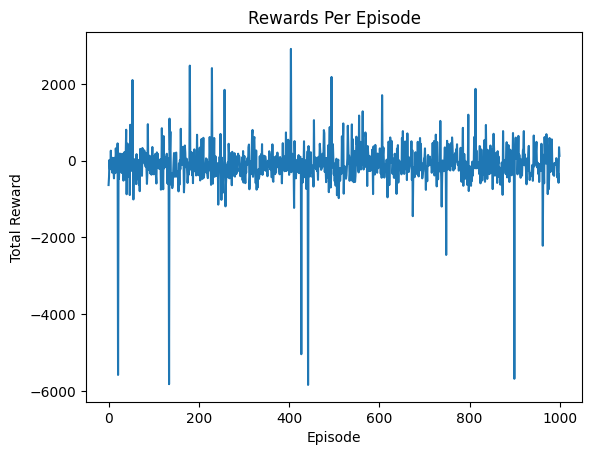

Testing trained agents...
Test Episode 1, Total Reward: -240.0
Test Episode 2, Total Reward: -2190.0
Test Episode 3, Total Reward: -230.0
Test Episode 4, Total Reward: -6200.0
Test Episode 5, Total Reward: -230.0
Test Episode 6, Total Reward: 4625.0
Test Episode 7, Total Reward: -240.0
Test Episode 8, Total Reward: -240.0
Test Episode 9, Total Reward: -2215.0
Test Episode 10, Total Reward: -240.0


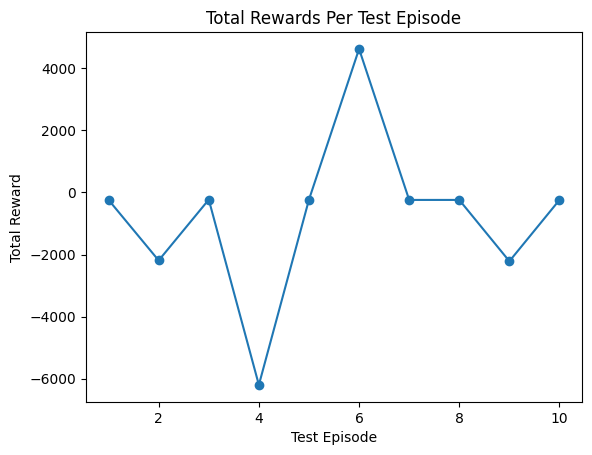

In [ ]:
def test_independent_a3c(env, agents, num_agents, num_test_episodes=10):
    total_rewards_per_episode = []

    for episode in range(num_test_episodes):
        state, _ = env.reset()
        total_rewards = np.zeros(num_agents)

        for step in range(MAX_STEPS):
            # Select the optimal action for each agent (greedy policy)
            actions = []
            for i in range(num_agents):
                state_tensor = torch.FloatTensor(state[i]).unsqueeze(0)
                action_probs, _ = agents[i].model(state_tensor)
                action = torch.argmax(action_probs).item()  # Greedy action
                actions.append(action)

            # Step through the environment with the selected actions
            next_state, rewards, terminated, truncated, _ = env.step(actions)
            total_rewards += rewards

            if terminated or truncated:
                break

            state = next_state

        # Track total reward for this episode
        total_rewards_per_episode.append(total_rewards.sum())
        print(f"Test Episode {episode + 1}, Total Reward: {total_rewards.sum()}")

    # Plot rewards
    plt.plot(range(1, num_test_episodes + 1), total_rewards_per_episode, marker='o')
    plt.xlabel('Test Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards Per Test Episode')
    plt.show()

# Example Integration with the Training Code
if __name__ == "__main__":
    num_agents = 2
    env = MultiAgentEnv(num_agents=num_agents, grid_size=5, obstacle_count=2)
    train_independent_a3c(env, num_agents)

    # Re-initialize agents with trained weights
    agents = [IndependentA3CAgent(env.observation_space.shape[1], env.action_space.nvec[0], i) for i in range(num_agents)]

    # Test the trained agents
    print("Testing trained agents...")
    test_independent_a3c(env, agents, num_agents)